In [64]:
import pandas as pd
import ast 
from collections import defaultdict
import numpy as np 
import matplotlib.pyplot as plt
import re
from transformers import pipeline


In [65]:
data = pd.read_csv("../data/processed/notes_2024_fqdn_selected.csv")
data["fqdn_replaced"] = data["fqdn_replaced"].apply(ast.literal_eval)
data["fqdn_selected"] = data["fqdn_selected"].apply(ast.literal_eval)
data["fqdn"] = data["fqdn"].apply(ast.literal_eval)
data.head()

,summary,currentStatus,createdAtMillis,datetime,fqdn,fqdn_replaced,fqdn_selected
0,Trump posted on Truth Social on 12/30/2023 tha...,CURRENTLY_RATED_HELPFUL,1704054854654,2024-01-01,"[www.newsweek.com, pbs.twimg.com, truthsocial....","[www.newsweek.com, www.pbs.org, truthsocial.com]","[www.newsweek.com, www.pbs.org, truthsocial.com]"
1,This has been refuted multiple times as false....,CURRENTLY_RATED_HELPFUL,1704090450017,2024-01-01,"[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]"
2,"This story was updated, originally reporting t...",CURRENTLY_RATED_HELPFUL,1704126932804,2024-01-02,"[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]"
3,This is not true. Joe Biden led the 2020 Democ...,CURRENTLY_RATED_HELPFUL,1704143134287,2024-01-02,"[www.realclearpolitics.com, www.politico.com]","[www.realclearpolitics.com, www.politico.com]",[www.politico.com]
4,Author has posted a selectively edited photo o...,CURRENTLY_RATED_HELPFUL,1704154725026,2024-01-02,[t.co],[x.com],[x.com]


## Measurement of Factuality

In [66]:
node_status_count = defaultdict(lambda: {"helpful": 0, "not_helpful": 0})

for fqdn_set, status in zip(data["fqdn_selected"], data["currentStatus"]):
    for fqdn in set(fqdn_set):  
        if status == "CURRENTLY_RATED_HELPFUL":
            node_status_count[fqdn]["helpful"] += 1
        elif status == "CURRENTLY_RATED_NOT_HELPFUL":
            node_status_count[fqdn]["not_helpful"] += 1

# DataFrame化
df_nodes = pd.DataFrame([
    {
        "fqdn": fqdn,
        "helpful": counts["helpful"],
        "not_helpful": counts["not_helpful"],
        "total": counts["helpful"] + counts["not_helpful"],
        "helpful_ratio": counts["helpful"] / (counts["helpful"] + counts["not_helpful"]) if (counts["helpful"] + counts["not_helpful"]) > 0 else None
    }
    for fqdn, counts in node_status_count.items()
])

df_nodes = df_nodes.sort_values(by = "total", ascending= False)
df_nodes.head(5)

,fqdn,helpful,not_helpful,total,helpful_ratio
9,x.com,565,223,788,0.717005
18,en.m.wikipedia.org,107,151,258,0.414729
23,www.youtube.com,199,54,253,0.786561
4,www.reuters.com,206,28,234,0.880342
5,apnews.com,136,61,197,0.690355


In [69]:
def bootstrap_helpful_sign(data_list, n_bootstrap=10000, alpha=0.05):
    n = len(data_list)
    if n == 0:
        return np.nan, np.nan, np.nan
    
    boot_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data_list, size=n, replace=True)
        boot_means.append(np.mean(sample))
    
    lower = np.percentile(boot_means, 100 * (alpha/2))
    upper = np.percentile(boot_means, 100 * (1 - alpha/2))
    mean = np.mean(boot_means)
    return mean, lower, upper

means = []
lowers = []
uppers = []
labels = []

for idx, row in df_nodes.iterrows():
    data_list = [1] * int(row["helpful"]) + [-1] * int(row["not_helpful"])
    mean, lower, upper = bootstrap_helpful_sign(data_list)
    
    means.append(mean)
    lowers.append(lower)
    uppers.append(upper)
    labels.append(idx)

df_nodes["mean"] = means
df_nodes["ci_lower"] = lowers
df_nodes["ci_upper"] = uppers

df_nodes.to_csv("../data/processed/helpful_score.csv", index=False, header=True)
df_nodes.head()

,fqdn,helpful,not_helpful,total,helpful_ratio,mean_helpful_sign,lower_helpful_sign,upper_helpful_sign,helpful_class,mean,ci_lower,ci_upper
9,x.com,565,223,788,0.717005,0.433873,0.370558,0.497462,helpful,0.434152,0.370558,0.497462
18,en.m.wikipedia.org,107,151,258,0.414729,-0.169806,-0.286822,-0.054070,not_helpful,-0.170142,-0.294574,-0.046512
23,www.youtube.com,199,54,253,0.786561,0.573227,0.470356,0.667984,helpful,0.573227,0.470356,0.667984
4,www.reuters.com,206,28,234,0.880342,0.760748,0.675214,0.837607,helpful,0.759959,0.675214,0.837607
5,apnews.com,136,61,197,0.690355,0.380835,0.248731,0.502538,helpful,0.381068,0.248731,0.512690


In [13]:
domain_to_name = {
    'www.google.com': 'Google',
    'nypost.com': 'New York Post',
    'www.msn.com': 'MSN',
    'www.axios.com': 'Axios',
    'truthsocial.com': 'Truth Social',
    'thehill.com': 'The Hill',
    'www.dailymail.co.uk': 'Daily Mail',
    'x.com': 'X (formerly Twitter)',
    'www.foxnews.com': 'Fox News',
    'www.npr.org': 'NPR',
    'en.m.wikipedia.org': 'Wikipedia',
    'www.cnn.com': 'CNN',
    'www.cbsnews.com': 'CBS News',
    'www.nytimes.com': 'New York Times',
    'www.pbs.org': 'PBS',
    'www.washingtonpost.com': 'Washington Post',
    'www.whitehouse.gov': 'White House',
    'abcnews.go.com': 'ABC News',
    'www.usatoday.com': 'USA Today',
    'apnews.com': 'AP News',
    'www.nbcnews.com': 'NBC News',
    'www.newsweek.com': 'Newsweek',
    'www.politico.com': 'Politico',
    'www.forbes.com': 'Forbes',
    'www.bbc.com': 'BBC',
    'www.theguardian.com': 'The Guardian',
    'www.donaldjtrump.com': 'Donald J. Trump',
    'www.independent.co.uk': 'The Independent',
    'www.reuters.com': 'Reuters',
    'www.politifact.com': 'PolitiFact',
    'www.youtube.com': 'YouTube',
    'www.yahoo.com': 'Yahoo',
    'www.factcheck.org': 'FactCheck.org',
    'www.snopes.com': 'Snopes',
    'www.instagram.com': 'Instagram',
    'www.gettyimages.com': 'Getty Images',
}

df_nodes["fqdn"] = df_nodes["fqdn"].map(domain_to_name)

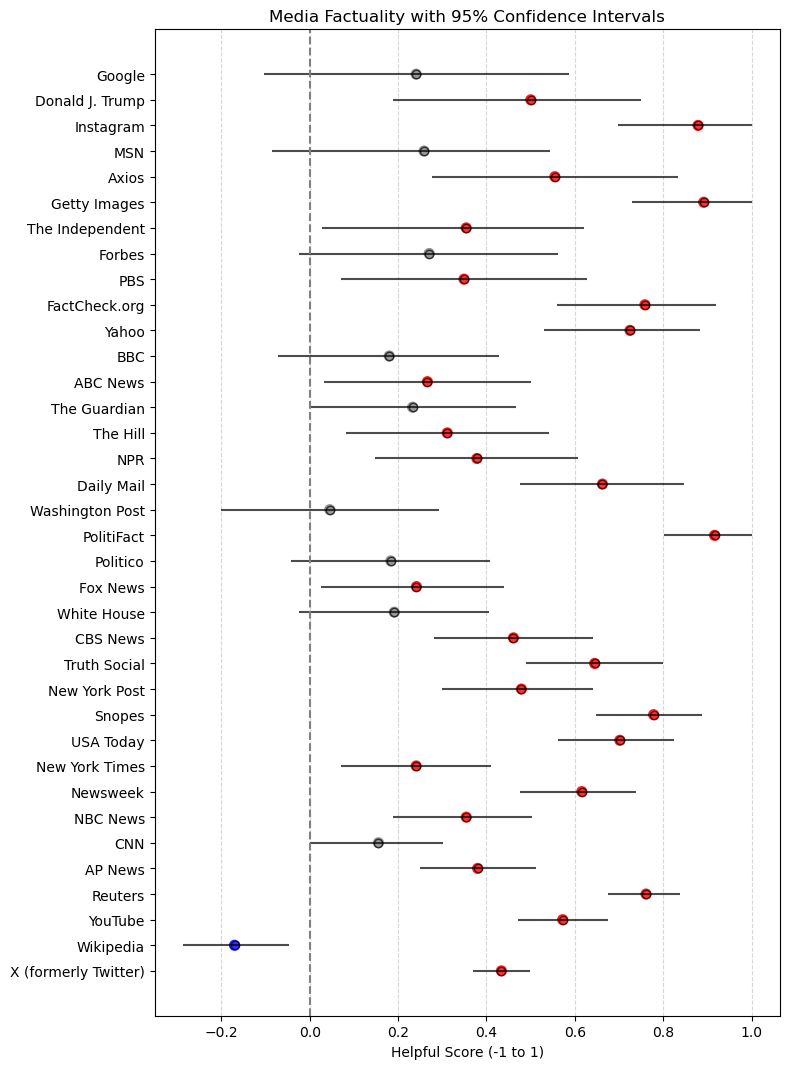

In [14]:
# set color by helpful_class
colors = df_nodes["helpful_class"].map({"helpful": "red", "not_helpful": "blue", "uncertain": "gray"})
medias = df_nodes["fqdn"].unique()
fig, ax = plt.subplots(figsize=(8, len(medias) * 0.3))


# draw error bars
plt.errorbar(
    df_nodes["mean_helpful_sign"], df_nodes["fqdn"],
    xerr=[df_nodes["mean_helpful_sign"] - df_nodes["lower_helpful_sign"],
          df_nodes["upper_helpful_sign"] - df_nodes["mean_helpful_sign"]],
    fmt='o',  
    ecolor='black', 
    alpha=0.7,
    markerfacecolor='none',
    markeredgecolor='black'
)

# change color based on helpful_class
plt.scatter(df_nodes["mean_helpful_sign"], df_nodes["fqdn"], color=colors, s=50, alpha=0.8)

# y axis : fqdn
plt.yticks(df_nodes["fqdn"], df_nodes["fqdn"])

plt.xlabel("Helpful Score (-1 to 1)")
plt.title("Media Factuality with 95% Confidence Intervals")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--') 

plt.tight_layout()
fig.savefig("../figure/figure1.pdf", dpi=300)
plt.show()

## Measurement of Bias

In [18]:
# before NLP, I need to filter out URLs from the summary
data["summary_filtered"] = data["summary"].apply(lambda x: re.sub(r'https://\S+', '', x))

In [19]:
# use a model of "matous-volf/political-leaning-deberta-large"
pipe = pipeline(
    "text-classification",
    model="matous-volf/political-leaning-deberta-large",
    tokenizer="microsoft/deberta-v3-large",
)


data["classification_result"] = data["summary_filtered"].apply(lambda x: pipe(x))

data[["classification_result"]]

/opt/anaconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use mps:0


,classification_result
0,"[{'label': 'LABEL_2', 'score': 0.9998847246170..."
1,"[{'label': 'LABEL_2', 'score': 0.9996803998947..."
2,"[{'label': 'LABEL_0', 'score': 0.9895700216293..."
3,"[{'label': 'LABEL_0', 'score': 0.9997561573982..."
4,"[{'label': 'LABEL_2', 'score': 0.9644505977630..."
...,...
4241,"[{'label': 'LABEL_2', 'score': 0.9914633631706..."
4242,"[{'label': 'LABEL_0', 'score': 0.6302886009216..."
4243,"[{'label': 'LABEL_2', 'score': 0.9454639554023..."
4244,"[{'label': 'LABEL_0', 'score': 0.9173019528388..."


In [20]:
data["classification_label"] = data["classification_result"].apply(lambda x: x[0]["label"])
data["classification_score"] = data["classification_result"].apply(lambda x: x[0]["score"])
data.head()

,summary,currentStatus,createdAtMillis,datetime,fqdn,fqdn_replaced,fqdn_selected,summary_filtered,classification_result,classification_label,classification_score
0,Trump posted on Truth Social on 12/30/2023 tha...,CURRENTLY_RATED_HELPFUL,1704054854654,2024-01-01,"[www.newsweek.com, pbs.twimg.com, truthsocial....","[www.newsweek.com, www.pbs.org, truthsocial.com]","[www.newsweek.com, www.pbs.org, truthsocial.com]",Trump posted on Truth Social on 12/30/2023 tha...,"[{'label': 'LABEL_2', 'score': 0.9998847246170...",LABEL_2,0.999885
1,This has been refuted multiple times as false....,CURRENTLY_RATED_HELPFUL,1704090450017,2024-01-01,"[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]",This has been refuted multiple times as false....,"[{'label': 'LABEL_2', 'score': 0.9996803998947...",LABEL_2,0.999680
2,"This story was updated, originally reporting t...",CURRENTLY_RATED_HELPFUL,1704126932804,2024-01-02,"[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","This story was updated, originally reporting t...","[{'label': 'LABEL_0', 'score': 0.9895700216293...",LABEL_0,0.989570
3,This is not true. Joe Biden led the 2020 Democ...,CURRENTLY_RATED_HELPFUL,1704143134287,2024-01-02,"[www.realclearpolitics.com, www.politico.com]","[www.realclearpolitics.com, www.politico.com]",[www.politico.com],This is not true. Joe Biden led the 2020 Democ...,"[{'label': 'LABEL_0', 'score': 0.9997561573982...",LABEL_0,0.999756
4,Author has posted a selectively edited photo o...,CURRENTLY_RATED_HELPFUL,1704154725026,2024-01-02,[t.co],[x.com],[x.com],Author has posted a selectively edited photo o...,"[{'label': 'LABEL_2', 'score': 0.9644505977630...",LABEL_2,0.964451


In [41]:
data.to_csv("../data/processed/notes_2024_fqdn_selected_with_classification.csv", index=False)

In [59]:
data = pd.read_csv("../data/processed/notes_2024_fqdn_selected_with_classification.csv")
data["fqdn_replaced"] = data["fqdn_replaced"].apply(ast.literal_eval)
data["fqdn_selected"] = data["fqdn_selected"].apply(ast.literal_eval)
data["fqdn"] = data["fqdn"].apply(ast.literal_eval)
data.head()

,summary,currentStatus,createdAtMillis,datetime,fqdn,fqdn_replaced,fqdn_selected,summary_filtered,classification_result,classification_label,classification_score
0,Trump posted on Truth Social on 12/30/2023 tha...,CURRENTLY_RATED_HELPFUL,1704054854654,2024-01-01,"[www.newsweek.com, pbs.twimg.com, truthsocial....","[www.newsweek.com, www.pbs.org, truthsocial.com]","[www.newsweek.com, www.pbs.org, truthsocial.com]",Trump posted on Truth Social on 12/30/2023 tha...,"[{'label': 'LABEL_2', 'score': 0.9998847246170...",LABEL_2,0.999885
1,This has been refuted multiple times as false....,CURRENTLY_RATED_HELPFUL,1704090450017,2024-01-01,"[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]",This has been refuted multiple times as false....,"[{'label': 'LABEL_2', 'score': 0.9996803998947...",LABEL_2,0.999680
2,"This story was updated, originally reporting t...",CURRENTLY_RATED_HELPFUL,1704126932804,2024-01-02,"[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","This story was updated, originally reporting t...","[{'label': 'LABEL_0', 'score': 0.9895700216293...",LABEL_0,0.989570
3,This is not true. Joe Biden led the 2020 Democ...,CURRENTLY_RATED_HELPFUL,1704143134287,2024-01-02,"[www.realclearpolitics.com, www.politico.com]","[www.realclearpolitics.com, www.politico.com]",[www.politico.com],This is not true. Joe Biden led the 2020 Democ...,"[{'label': 'LABEL_0', 'score': 0.9997561573982...",LABEL_0,0.999756
4,Author has posted a selectively edited photo o...,CURRENTLY_RATED_HELPFUL,1704154725026,2024-01-02,[t.co],[x.com],[x.com],Author has posted a selectively edited photo o...,"[{'label': 'LABEL_2', 'score': 0.9644505977630...",LABEL_2,0.964451


In [60]:
expanded = data.explode('fqdn_selected')[['classification_label', 'fqdn_selected']]

# count occurrences of each label and fqdn
counts = expanded.value_counts().reset_index(name='count')

counts.columns = ['classification_label', 'fqdn', 'count']

# replace classification labels with more readable names
counts = counts.replace({"LABEL_2": "Right", "LABEL_1" : "Center", "LABEL_0" : "Left"})

counts.head()

,classification_label,fqdn,count
0,Right,x.com,542
1,Left,x.com,466
2,Left,www.youtube.com,163
3,Left,en.m.wikipedia.org,141
4,Left,www.reuters.com,135


In [61]:
pivot_df = counts.pivot_table(
    index="fqdn",
    columns="classification_label",
    values="count",
    aggfunc="sum",
    fill_value=0
)

counts_media = pivot_df[["Left", "Center", "Right"]]

counts_media = counts_media.reset_index()

counts_media.index = counts_media["fqdn"]
counts_media = counts_media.drop(columns = "fqdn")
counts_media["total"] = counts_media["Left"] + counts_media["Center"] + counts_media["Right"]
counts_media = counts_media.sort_values("total", ascending = False)
counts_media.head()

classification_label,Left,Center,Right,total
fqdn,,,,
x.com,466,42,542,1050
en.m.wikipedia.org,141,25,133,299
www.youtube.com,163,20,95,278
www.reuters.com,135,19,85,239
apnews.com,102,14,82,198


In [62]:
medias = set([m for sublist in data["fqdn_selected"] for m in sublist])
labels_map = {"LABEL_0": -1, "LABEL_1": 0, "LABEL_2": 1}

results = {}

for media in medias:

    indices = [i for i, domains in enumerate(data["fqdn_selected"]) if media in domains]
    if not indices:
        continue
    

    media_labels = [labels_map[data["classification_label"][i]] for i in indices]


    boot_means = []
    for _ in range(10000):
        sample = np.random.choice(media_labels, size=len(media_labels), replace=True)
        boot_means.append(np.mean(sample))

    mean_score = np.mean(boot_means)
    ci_lower = np.percentile(boot_means, 2.5)
    ci_upper = np.percentile(boot_means, 97.5)

    results[media] = {"mean": mean_score, "ci_lower": ci_lower, "ci_upper": ci_upper}

results = pd.DataFrame(results)
results = results.T
results = results.sort_values("mean")
results.head()

,mean,ci_lower,ci_upper
www.gettyimages.com,-0.542230,-0.783784,-0.270270
www.instagram.com,-0.393679,-0.696970,-0.090909
www.snopes.com,-0.314207,-0.481481,-0.138889
www.factcheck.org,-0.283230,-0.520000,-0.020000
www.yahoo.com,-0.272418,-0.509804,-0.019608


In [63]:
results = pd.concat([results, counts_media], axis=1)
results.to_csv("../data/processed/media_bias_score.csv", index=True, header=True)
results.head()

,mean,ci_lower,ci_upper,Left,Center,Right,total
www.gettyimages.com,-0.542230,-0.783784,-0.270270,31,1,8,40
www.instagram.com,-0.393679,-0.696970,-0.090909,27,0,10,37
www.snopes.com,-0.314207,-0.481481,-0.138889,67,8,34,109
www.factcheck.org,-0.283230,-0.520000,-0.020000,30,4,16,50
www.yahoo.com,-0.272418,-0.509804,-0.019608,31,3,17,51


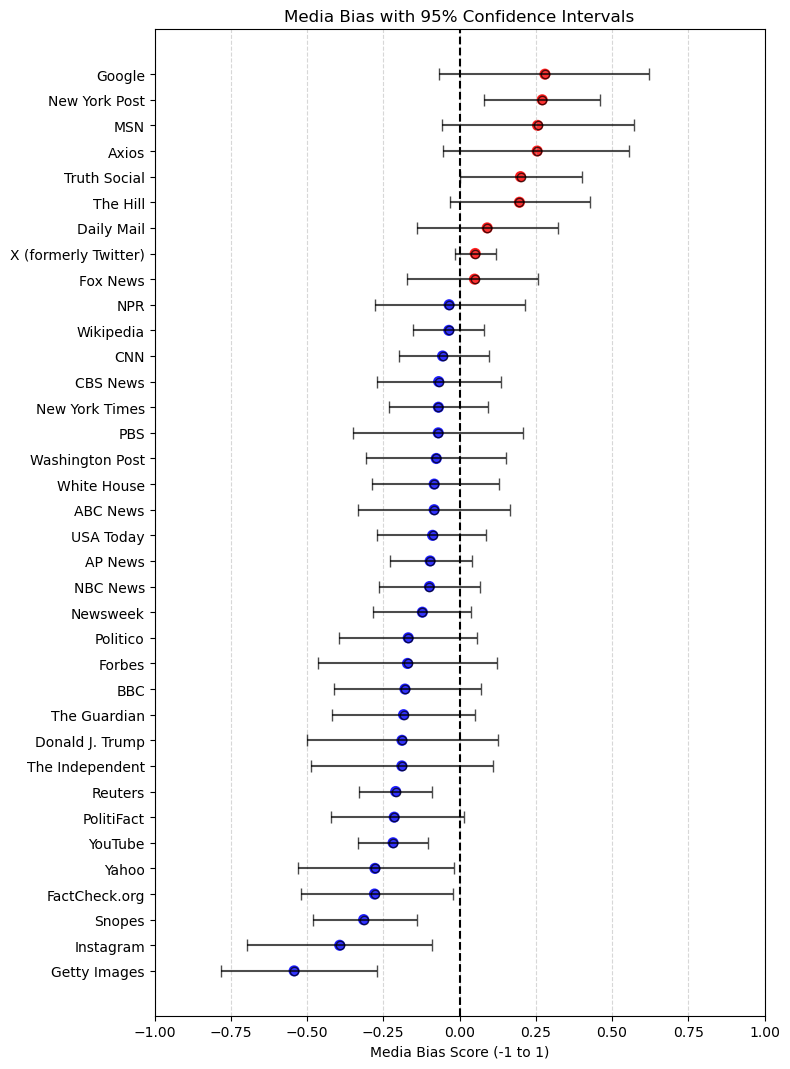

In [40]:
results.index = results.index.map(domain_to_name)


colors = results["mean"].apply(lambda x: "red" if x > 0 else ("blue" if x < 0 else "gray"))
medias = results.index
fig, ax = plt.subplots(figsize=(8, len(medias) * 0.3))

#draw error bars
plt.errorbar(
    results["mean"], results.index,
    xerr = [results["mean"] - results["ci_lower"], 
           results["ci_upper"] - results["mean"]],
    fmt ='o',
    ecolor='black',
    alpha=0.7,
    markerfacecolor = 'none',
    markeredgecolor = 'black',
    capsize = 4
)

# change color based on mean
plt.scatter(results["mean"], results.index, color=colors, s=50, alpha=0.8)

# y axis : fqdn
plt.yticks(results.index, results.index)

plt.xlim(-1, 1)
plt.xlabel("Media Bias Score (-1 to 1)")
plt.title("Media Bias with 95% Confidence Intervals")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle='--', label='Center (0)')
plt.tight_layout()
fig.savefig("../figure/figure2.pdf", dpi=300)
plt.show()